In [2]:
# -*- coding: utf-8 -*- 
# @Time : 2022/3/18 14:18 
# @Author : Orange
# @File : g_pred.py.py

# -*- coding: utf-8 -*- 
# @Time : 2022/3/18 14:18 
# @Author : Orange
# @File : g_pred.py.py

from decimal import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


Bad key "text.kerning_factor" on line 4 in
d:\Users\96212\anaconda3\envs\ML\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
class GM11():
    def __init__(self):
        self.f = None

    def isUsable(self, X0):
        '''判断是否通过光滑检验'''
        X1 = X0.cumsum()
        rho = [X0[i] / X1[i - 1] for i in range(1, len(X0))]
        rho_ratio = [rho[i + 1] / rho[i] for i in range(len(rho) - 1)]
        print(rho, rho_ratio)
        flag = True
        for i in range(2, len(rho) - 1):
            if rho[i] > 0.5 or rho[i + 1] / rho[i] >= 1:
                flag = False
        if rho[-1] > 0.5:
            flag = False
        if flag:
            print("数据通过光滑校验")
        else:
            print("该数据未通过光滑校验")

        '''判断是否通过级比检验'''
        lambds = [X0[i - 1] / X0[i] for i in range(1, len(X0))]
        X_min = np.e ** (-2 / (len(X0) + 1))
        X_max = np.e ** (2 / (len(X0) + 1))
        for lambd in lambds:
            if lambd < X_min or lambd > X_max:
                print('该数据未通过级比检验')
                return
        print('该数据通过级比检验')

    def train(self, X0):
        X1 = X0.cumsum(axis=0)  # [x_2^1,x_3^1,...,x_n^1,x_1^1] # 其中x_i^1为x_i^01次累加后的列向量
        Z = (np.array([-0.5 * (X1[:, -1][k - 1] + X1[:, -1][k]) for k in range(1, len(X1[:, -1]))])).reshape(
            len(X1[:, -1]) - 1, 1)
        # 数据矩阵A、B
        A = (X0[:, -1][1:]).reshape(len(Z), 1)
        B = np.hstack((Z, X1[1:, :-1]))
        # 求参数
        u = np.linalg.inv(np.matmul(B.T, B)).dot(B.T).dot(A)
        a = u[0][0]
        b = u[1:]
        print("灰参数a：", a, "，参数矩阵b：", b)
        self.f = lambda k, X1: (X0[0, -1] - (1 / a) * (X1[k, ::]).dot(b)) * np.exp(-a * k) + (1 / a) * (X1[k, ::]).dot(
            b)

    def predict(self, k, X0):
        '''
        :param k: k为预测的第k个值
        :param X0: X0为【k*n】的矩阵,n为特征的个数，k为样本的个数
        :return:
        '''
        X1 = X0.cumsum(axis=0)
        X1_hat = [float(self.f(k, X1)) for k in range(k)]
        X0_hat = np.diff(X1_hat)
        X0_hat = np.hstack((X1_hat[0], X0_hat))
        return X0_hat

    def evaluate(self, X0_hat, X0):
        '''
        根据后验差比及小误差概率判断预测结果
        :param X0_hat: 预测结果
        :return:
        '''
        S1 = np.std(X0, ddof=1)  # 原始数据样本标准差
        S2 = np.std(X0 - X0_hat, ddof=1)  # 残差数据样本标准差
        C = S2 / S1  # 后验差比
        Pe = np.mean(X0 - X0_hat)
        temp = np.abs((X0 - X0_hat - Pe)) < 0.6745 * S1
        p = np.count_nonzero(temp) / len(X0)  # 计算小误差概率
        print("原数据样本标准差：", S1)
        print("残差样本标准差：", S2)
        print("后验差：", C)
        print("小误差概率p：", p)

In [4]:
datas = pd.read_csv(r"data/gmdata.csv")
datas

,日期,降水量(mm),土壤蒸发量(W/m2),植被指数(NDVI),径流量(m3/s),"低层植被(LAIL,m2/m2)",10cm湿度(kg/m2),40cm湿度(kg/m2),100cm湿度(kg/m2),200cm湿度(kg/m2)
0,202004,101.35,10.51,0.187,0.177083,0.64800,13.73,33.65,46.99,166.70
1,202005,68.07,19.89,0.176,0.132056,0.63600,16.51,34.02,46.68,166.70
2,202006,7.37,23.21,0.187,0.133333,0.65200,17.01,40.00,46.43,166.67
3,202007,5.59,30.21,0.258,0.196573,0.71700,21.31,56.60,54.24,166.62
4,202008,3.56,23.02,0.605,0.198085,0.72700,20.79,56.63,68.52,166.51
5,202009,4.57,16.95,0.581,0.263021,0.73900,20.04,56.67,76.04,166.32
6,202010,30.73,11.19,0.467,0.264113,0.82700,16.59,52.88,80.84,166.09
7,202011,2.54,2.43,0.278,0.196615,0.96400,15.04,50.66,82.25,165.95
8,202012,2.54,1.41,0.219,0.145665,0.98300,16.51,50.40,82.44,165.92
9,202101,6.10,1.05,0.191,0.066532,0.72653,15.17,50.40,82.44,165.92


In [5]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False  # 步骤二（解决坐标轴负数的负号显示问题）
# data = pd.read_csv(r"data/data.csv")

data10 = datas[['日期','降水量(mm)','土壤蒸发量(W/m2)','植被指数(NDVI)','径流量(m3/s)','低层植被(LAIL,m2/m2)','10cm湿度(kg/m2)']]
data40 = datas[['日期','降水量(mm)','土壤蒸发量(W/m2)','植被指数(NDVI)','径流量(m3/s)','低层植被(LAIL,m2/m2)','40cm湿度(kg/m2)']]
data100 = datas[['日期','降水量(mm)','土壤蒸发量(W/m2)','植被指数(NDVI)','径流量(m3/s)','低层植被(LAIL,m2/m2)','100cm湿度(kg/m2)']]
data200 = datas[['日期','降水量(mm)','土壤蒸发量(W/m2)','植被指数(NDVI)','径流量(m3/s)','低层植被(LAIL,m2/m2)','200cm湿度(kg/m2)']]

In [6]:
# data.drop('供水总量', axis=1, inplace=True)
# 原始数据X
X10 = data10.values
X40 = data40.values
X100 = data100.values
X200 = data200.values

In [7]:
# 训练集
X10_train = X10[:, :]
X40_train = X40[:, :]
X100_train = X100[:, :]
X200_train = X200[:, :]

In [8]:
# 测试集
X10_test = []
X40_test = []
X100_test = []
X200_test = []

In [9]:
model10 = GM11()
model40 = GM11()
model100 = GM11()
model200 = GM11()

In [10]:
model10.isUsable(X10_train[:, -1])  # 判断模型可行性
model40.isUsable(X40_train[:, -1])  # 判断模型可行性
model100.isUsable(X100_train[:, -1])  # 判断模型可行性
model200.isUsable(X200_train[:, -1])  # 判断模型可行性

[1.202476329206118, 0.5625, 0.45100529100529096, 0.30323803967327884, 0.2242865137101287, 0.1516592010238596, 0.11938402921098587, 0.1170755921145937, 0.09629911762838826, 0.08066010422698322, 0.0769972673203665, 0.07054726368159205, 0.0686402081977879, 0.07679930419656447, 0.0892532611768507, 0.07548848763486708, 0.07243079256731134, 0.05442329947280442, 0.042407243681595076, 0.038430042115114645, 0.03506449614149721, 0.03292427416941036, 0.03940886699507389] [0.4677846759539673, 0.8017871840094062, 0.672360270978997, 0.7396384502148353, 0.676185110353386, 0.7871861938149333, 0.9806637695875342, 0.8225379508149794, 0.8375996189107887, 0.9545892366279464, 0.9162307460609271, 0.9729676902507312, 1.1188675881527923, 1.1621623673622208, 0.8457784806909248, 0.9594945512440836, 0.7513834592135353, 0.7792111851429767, 0.9062140987907084, 0.9124240883333886, 0.938963276031393, 1.1969547693685625]
该数据未通过光滑校验
该数据未通过级比检验
[1.010995542347697, 0.5911038865080538, 0.5256803194947525, 0.3447373227004

In [11]:
model10.train(X10_train)  # 训练
model40.train(X40_train)  # 训练
model100.train(X100_train)  # 训练
model200.train(X200_train)  # 训练

灰参数a： 0.8956791363533353 ，参数矩阵b： [[ 6.56965884e-05]
 [-3.54904537e-03]
 [ 2.97186061e-01]
 [ 1.23868433e+00]
 [-3.01638486e+00]
 [-1.38573994e+00]]
灰参数a： 0.6090862398997804 ，参数矩阵b： [[ 1.39735324e-04]
 [-5.39317874e-02]
 [ 3.50455117e-01]
 [-7.64934382e+00]
 [ 4.46465472e+00]
 [ 3.48329963e+00]]
灰参数a： 0.35887444277293046 ，参数矩阵b： [[ 2.57854876e-04]
 [-5.97965635e-03]
 [-4.16727246e-01]
 [ 1.95895193e+01]
 [ 7.97197938e+00]
 [-2.99695900e+01]]
灰参数a： 2.032879763193999 ，参数矩阵b： [[ 1.63686287e-03]
 [ 2.52675433e-02]
 [ 1.21547192e-01]
 [ 1.31572317e+00]
 [-1.27335373e+01]
 [ 8.84929139e+00]]


In [12]:
Y10_pred = model10.predict(len(X10), X10[:, :-1])  # 预测
Y40_pred = model40.predict(len(X40), X40[:, :-1])  # 预测
Y100_pred = model100.predict(len(X100), X100[:, :-1])  # 预测
Y200_pred = model200.predict(len(X200), X200[:, :-1])  # 预测

In [13]:
Y10_pred

array([13.73      , 13.48604134, 23.24660536, 26.15932468, 23.60691326,
       20.44284598, 17.53332113, 14.16102309, 13.71155321, 14.12931421,
       13.91647306, 11.96811977, 15.78153331, 18.39910231, 21.47972279,
       22.39525422, 18.6572433 , 17.94036711, 16.15992633, 13.23728949,
       13.15513454, 13.44585764, 13.53118022, 12.9654045 ])

In [14]:
Y10_train_pred = Y10_pred[:len(X10_train)]
Y40_train_pred = Y40_pred[:len(X40_train)]
Y100_train_pred = Y100_pred[:len(X100_train)]
Y200_train_pred = Y200_pred[:len(X200_train)]

In [15]:
Y10_test_pred = Y10_pred[len(X10_train):]
Y40_test_pred = Y40_pred[len(X40_train):]
Y100_test_pred = Y100_pred[len(X100_train):]
Y200_test_pred = Y200_pred[len(X200_train):]

In [16]:
score_tRAIN = model10.evaluate(Y10_train_pred, X10_train[:, -1])  # 评估
print("========================")
score_tRAIN = model40.evaluate(Y40_train_pred, X40_train[:, -1])  # 评估
print("========================")
score_tRAIN = model100.evaluate(Y100_train_pred, X100_train[:, -1])  # 评估
print("========================")
score_tRAIN = model200.evaluate(Y200_train_pred, X200_train[:, -1])  # 评估

原数据样本标准差： 3.0188357663274714
残差样本标准差： 2.4992700784246953
后验差： 0.8278920325185999
小误差概率p： 0.5416666666666666
原数据样本标准差： 6.799697350468697
残差样本标准差： 6.242091452862891
后验差： 0.9179954829066957
小误差概率p： 0.7083333333333334
原数据样本标准差： 15.20215258761408
残差样本标准差： 13.09129128151311
后验差： 0.8611472096510339
小误差概率p： 0.5416666666666666
原数据样本标准差： 0.8064845883861298
残差样本标准差： 5.895503241703677
后验差： 7.310125111629561
小误差概率p： 0.4583333333333333


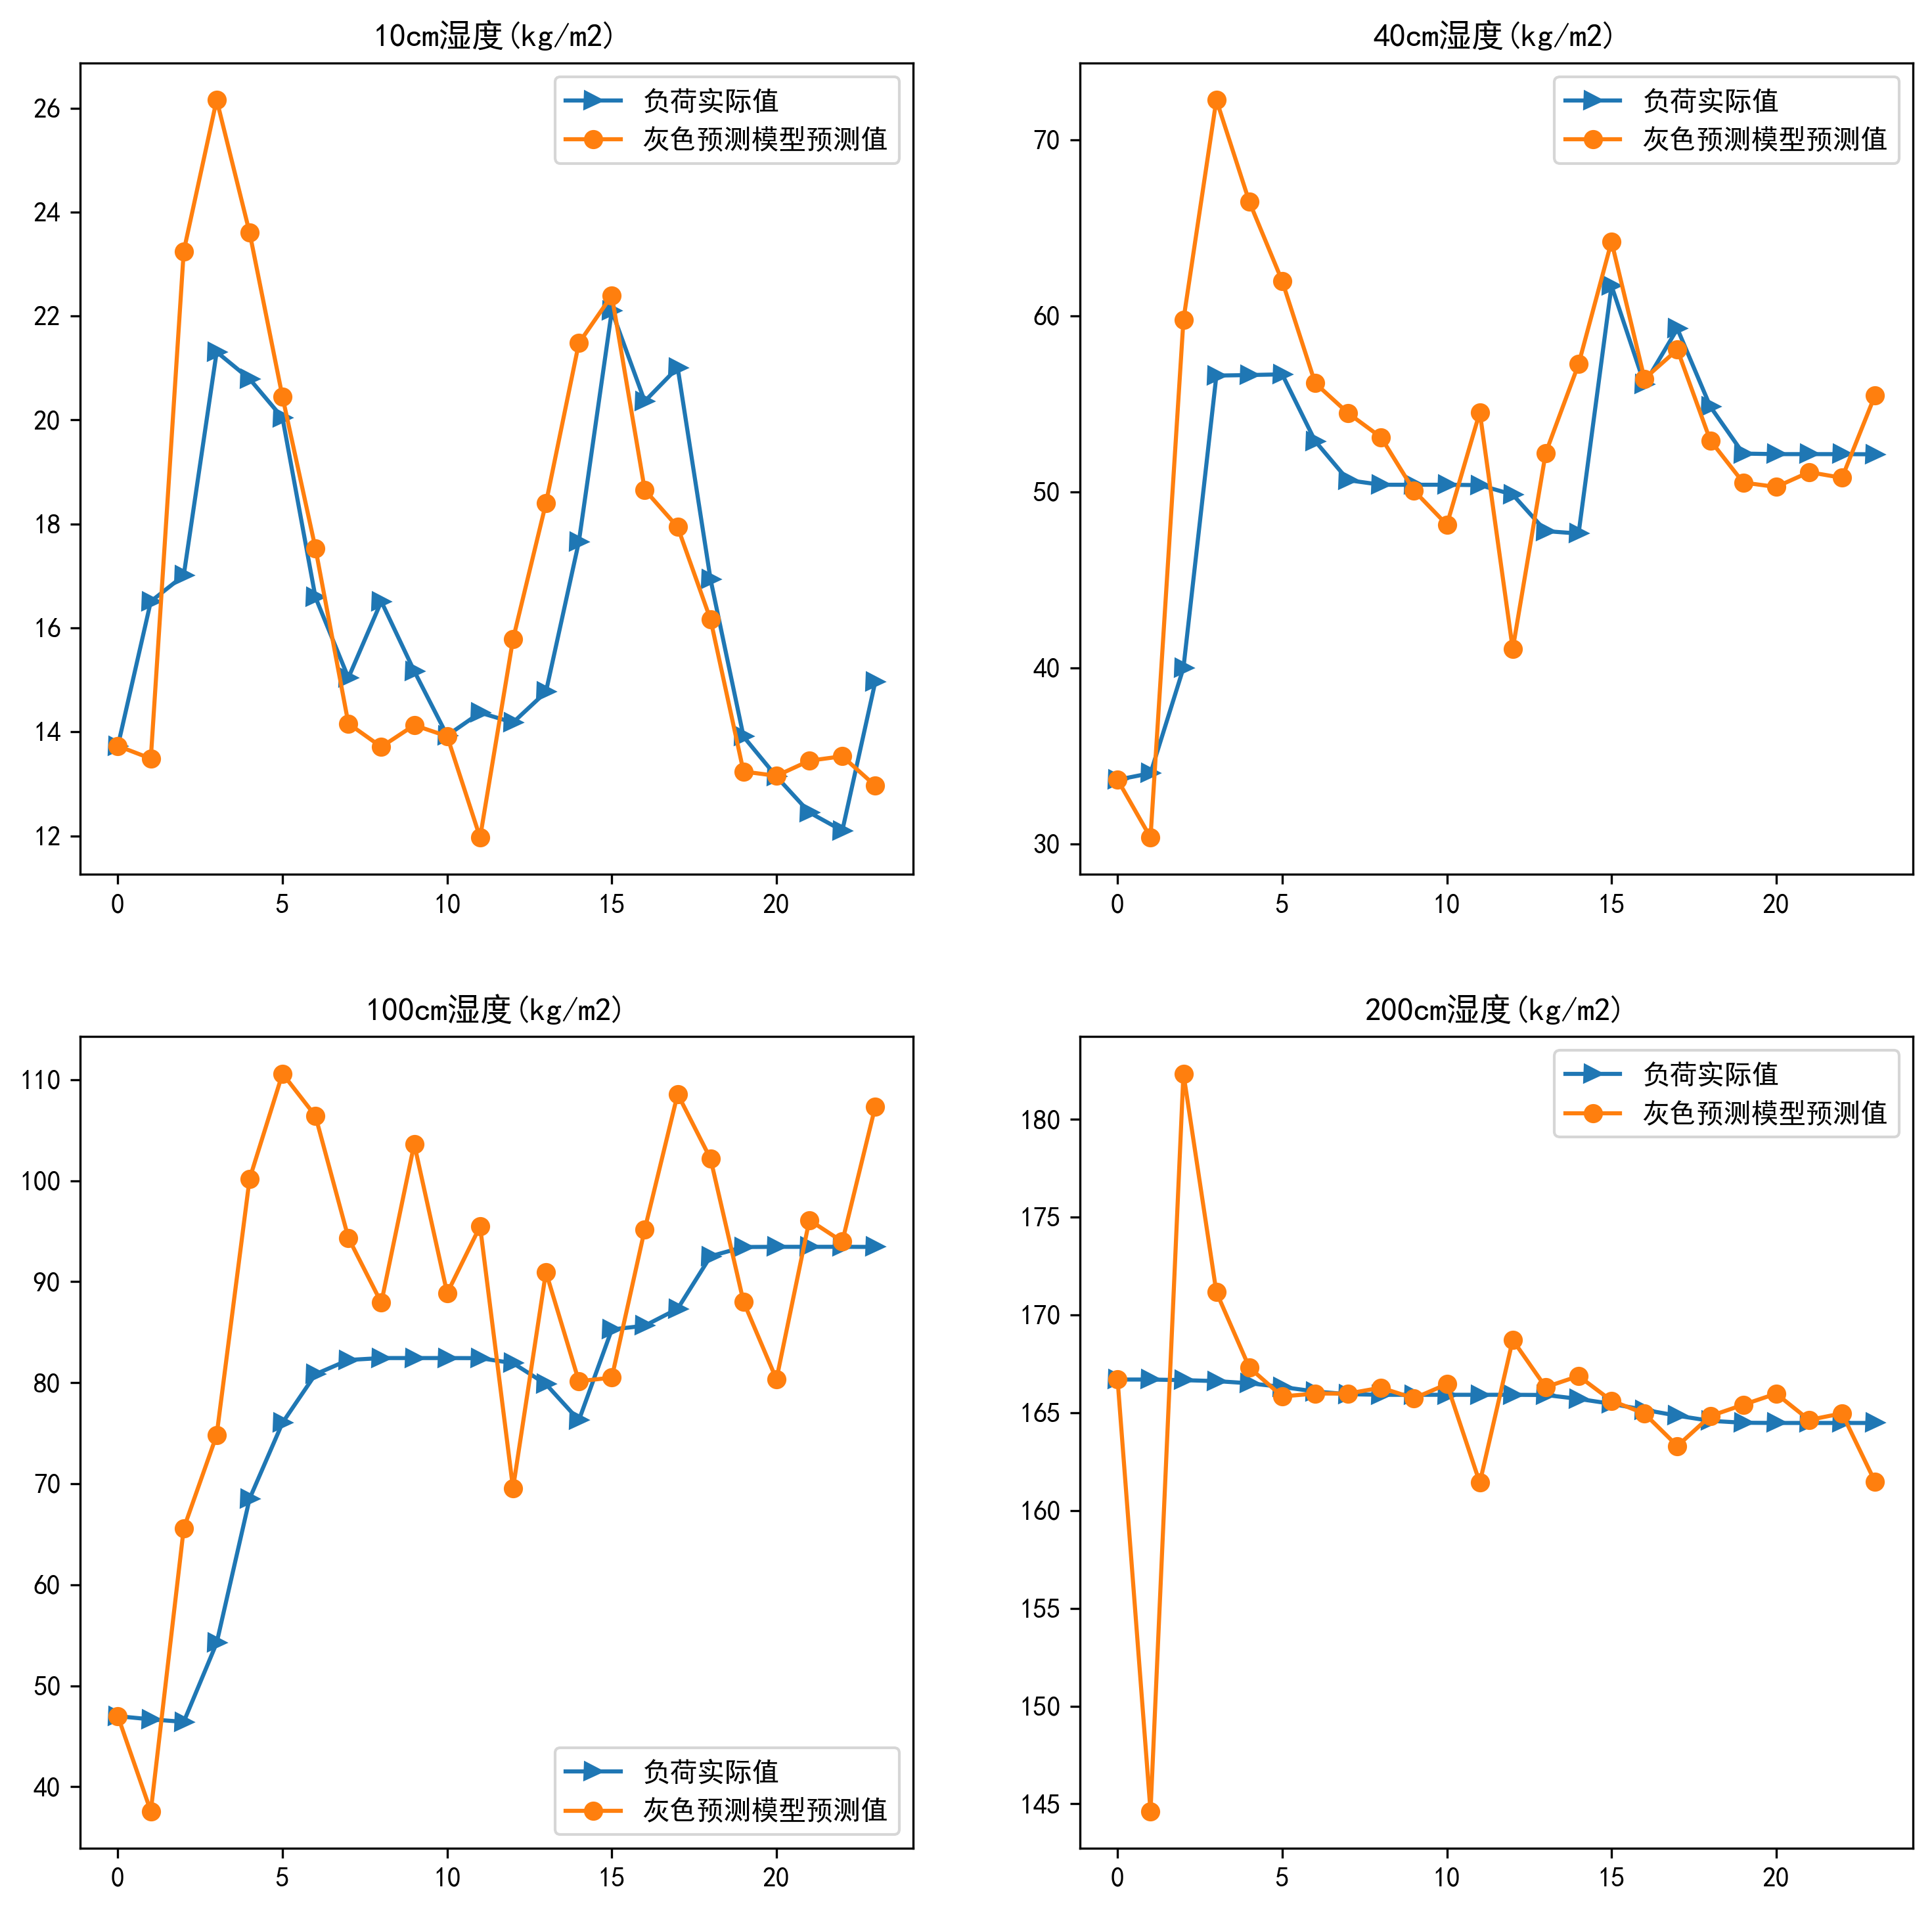

In [17]:
# score_test = model.evaluate(Y_test_pred, X_test[:, -1])

# 可视化
# plt.grid()
# fig = plt.figure(figsize=(16,6))
plt.figure(figsize=(12, 12),dpi=300)

# ax1 = fig.add_axes([0.1,0.1,0.4,0.8]) 
plt.subplot(2,2,1)  #创建两行两列的子图，并绘制第一个子图
plt.plot(np.arange(len(Y10_train_pred)), X10_train[:, -1], '->')
plt.plot(np.arange(len(Y10_train_pred)), Y10_train_pred, '-o')
plt.title('10cm湿度(kg/m2)')
# plt.axis(xmin=-2*np.pi, xmax=2*np.pi, ymin=-1, ymax=1)  # 在axes1中设置x轴和y轴显示范围
plt.legend(['负荷实际值', '灰色预测模型预测值'])
# plt.legend(loc=1)   # 在axes1中设置图例

# ax2 = fig.add_axes([0.6,0.1,0.4,0.8]) 
plt.subplot(2,2,2)  #创建两行两列的子图，并绘制第一个子图
plt.plot(np.arange(len(Y40_train_pred)), X40_train[:, -1], '->')
plt.plot(np.arange(len(Y40_train_pred)), Y40_train_pred, '-o')
plt.title('40cm湿度(kg/m2)')
plt.legend(['负荷实际值', '灰色预测模型预测值'])

# ax3 = fig.add_axes([0.1,0.1,0.4,0.8]) 
plt.subplot(2,2,3)  #创建两行两列的子图，并绘制第三个子图
plt.plot(np.arange(len(Y100_train_pred)), X100_train[:, -1], '->')
plt.plot(np.arange(len(Y100_train_pred)), Y100_train_pred, '-o')
plt.title('100cm湿度(kg/m2)')
plt.legend(['负荷实际值', '灰色预测模型预测值'])

# ax4 = fig.add_axes([0.6,0.1,0.4,0.8]) 
plt.subplot(2,2,4)  #创建两行两列的子图，并绘制第三个子图
plt.plot(np.arange(len(Y200_train_pred)), X200_train[:, -1], '->')
plt.plot(np.arange(len(Y200_train_pred)), Y200_train_pred, '-o')
plt.title('200cm湿度(kg/m2)')
plt.legend(['负荷实际值', '灰色预测模型预测值'])
plt.savefig('data/Q2.jpg')
plt.show()


[1.202476329206118, 0.5625, 0.45100529100529096, 0.30323803967327884, 0.2242865137101287, 0.1516592010238596, 0.11938402921098587, 0.1170755921145937, 0.09629911762838826, 0.08066010422698322, 0.0769972673203665, 0.07054726368159205, 0.0686402081977879, 0.07679930419656447, 0.0892532611768507, 0.07548848763486708, 0.07243079256731134, 0.05442329947280442, 0.042407243681595076, 0.038430042115114645, 0.03506449614149721, 0.03292427416941036, 0.03940886699507389] [0.4677846759539673, 0.8017871840094062, 0.672360270978997, 0.7396384502148353, 0.676185110353386, 0.7871861938149333, 0.9806637695875342, 0.8225379508149794, 0.8375996189107887, 0.9545892366279464, 0.9162307460609271, 0.9729676902507312, 1.1188675881527923, 1.1621623673622208, 0.8457784806909248, 0.9594945512440836, 0.7513834592135353, 0.7792111851429767, 0.9062140987907084, 0.9124240883333886, 0.938963276031393, 1.1969547693685625]
该数据未通过光滑校验
该数据未通过级比检验
灰参数a： 0.8956791363533353 ，参数矩阵b： [[ 6.56965884e-05]
 [-3.54904537e-03]
 [ 2

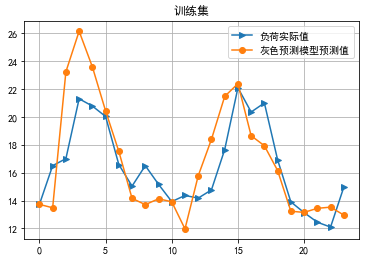

In [18]:
if __name__ == '__main__':
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 步骤一（替换sans-serif字体）
    plt.rcParams['axes.unicode_minus'] = False  # 步骤二（解决坐标轴负数的负号显示问题）
    # data = pd.read_csv(r"data/data.csv")
    datas = pd.read_csv(r"data/gmdata.csv")
    data = datas[['日期','降水量(mm)','土壤蒸发量(W/m2)','植被指数(NDVI)','径流量(m3/s)','低层植被(LAIL,m2/m2)','10cm湿度(kg/m2)']]
    # data.drop('供水总量', axis=1, inplace=True)
    # 原始数据X
    X = data.values
    # 训练集
    X_train = X[:, :]
    # 测试集
    X_test = []

    model = GM11()
    model.isUsable(X_train[:, -1])  # 判断模型可行性
    model.train(X_train)  # 训练
    Y_pred = model.predict(len(X), X[:, :-1])  # 预测
    Y_train_pred = Y_pred[:len(X_train)]
    Y_test_pred = Y_pred[len(X_train):]
    score_tRAIN = model.evaluate(Y_train_pred, X_train[:, -1])  # 评估
    # score_test = model.evaluate(Y_test_pred, X_test[:, -1])

    # 可视化
    plt.grid()
    plt.plot(np.arange(len(Y_train_pred)), X_train[:, -1], '->')
    plt.plot(np.arange(len(Y_train_pred)), Y_train_pred, '-o')
    plt.legend(['负荷实际值', '灰色预测模型预测值'])
    plt.title('训练集')
    plt.show()

    # # 可视化
    # plt.grid()
    # plt.plot(np.arange(len(Y_test_pred)), X_test[:, -1], '->')
    # plt.plot(np.arange(len(Y_test_pred)), Y_test_pred, '-o')
    # plt.legend(['负荷实际值', '灰色预测模型预测值'])
    # plt.title('测试集')
    # plt.show()

In [19]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False  # 步骤二（解决坐标轴负数的负号显示问题）
data = pd.read_csv(r"data/data.csv")

In [20]:
data

,年份,城区人口,建成区面积,供水总量,用水人口,人口综合用水指标,城市用水总量
0,2002,191.85,98.00,26396.00,150.10,175.86,33737.99
1,2003,195.96,98.00,25551.00,150.10,170.23,33357.59
2,2004,203.37,98.00,32661.00,200.00,163.31,33211.34
3,2005,206.31,129.00,24186.00,203.00,119.14,24580.36
4,2006,257.45,132.00,27194.00,208.33,130.53,33605.80
5,2007,217.27,132.00,24134.80,178.88,134.92,29314.45
6,2008,217.27,132.00,24427.20,203.00,120.33,26144.32
7,2009,217.27,175.00,23932.92,207.30,115.45,25083.96
8,2010,217.39,162.00,24397.00,209.18,116.63,25354.55
9,2011,251.00,162.00,25238.82,224.26,112.54,28248.21


In [21]:
datas = pd.read_csv(r"data/gmdata.csv")
data = datas[['日期','降水量(mm)','土壤蒸发量(W/m2)','植被指数(NDVI)','径流量(m3/s)','低层植被(LAIL,m2/m2)','10cm湿度(kg/m2)']]
data

,日期,降水量(mm),土壤蒸发量(W/m2),植被指数(NDVI),径流量(m3/s),"低层植被(LAIL,m2/m2)",10cm湿度(kg/m2)
0,202004,101.35,10.51,0.187,0.177083,0.64800,13.73
1,202005,68.07,19.89,0.176,0.132056,0.63600,16.51
2,202006,7.37,23.21,0.187,0.133333,0.65200,17.01
3,202007,5.59,30.21,0.258,0.196573,0.71700,21.31
4,202008,3.56,23.02,0.605,0.198085,0.72700,20.79
5,202009,4.57,16.95,0.581,0.263021,0.73900,20.04
6,202010,30.73,11.19,0.467,0.264113,0.82700,16.59
7,202011,2.54,2.43,0.278,0.196615,0.96400,15.04
8,202012,2.54,1.41,0.219,0.145665,0.98300,16.51
9,202101,6.10,1.05,0.191,0.066532,0.72653,15.17


In [22]:
X = data.values
# 训练集
X_train = X[:, :]
# 测试集
X_test = []

In [23]:
model = GM11()
model.isUsable(X_train[:, -1])  # 判断模型可行性

[1.202476329206118, 0.5625, 0.45100529100529096, 0.30323803967327884, 0.2242865137101287, 0.1516592010238596, 0.11938402921098587, 0.1170755921145937, 0.09629911762838826, 0.08066010422698322, 0.0769972673203665, 0.07054726368159205, 0.0686402081977879, 0.07679930419656447, 0.0892532611768507, 0.07548848763486708, 0.07243079256731134, 0.05442329947280442, 0.042407243681595076, 0.038430042115114645, 0.03506449614149721, 0.03292427416941036, 0.03940886699507389] [0.4677846759539673, 0.8017871840094062, 0.672360270978997, 0.7396384502148353, 0.676185110353386, 0.7871861938149333, 0.9806637695875342, 0.8225379508149794, 0.8375996189107887, 0.9545892366279464, 0.9162307460609271, 0.9729676902507312, 1.1188675881527923, 1.1621623673622208, 0.8457784806909248, 0.9594945512440836, 0.7513834592135353, 0.7792111851429767, 0.9062140987907084, 0.9124240883333886, 0.938963276031393, 1.1969547693685625]
该数据未通过光滑校验
该数据未通过级比检验


In [24]:
model.train(X_train)  # 训练

灰参数a： 0.8956791363533353 ，参数矩阵b： [[ 6.56965884e-05]
 [-3.54904537e-03]
 [ 2.97186061e-01]
 [ 1.23868433e+00]
 [-3.01638486e+00]
 [-1.38573994e+00]]


In [25]:
Y_pred = model.predict(len(X), X[:, :-1])  # 预测
Y_pred

array([13.73      , 13.48604134, 23.24660536, 26.15932468, 23.60691326,
       20.44284598, 17.53332113, 14.16102309, 13.71155321, 14.12931421,
       13.91647306, 11.96811977, 15.78153331, 18.39910231, 21.47972279,
       22.39525422, 18.6572433 , 17.94036711, 16.15992633, 13.23728949,
       13.15513454, 13.44585764, 13.53118022, 12.9654045 ])